In [97]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS, CartesianRepresentation, match_coordinates_sky
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle

### 函数定义

In [98]:
def work_sext(
    image_path: str,
    config_path: str,
    out_path: str,
    flag_path: str,
    weight_path: str,
    out_para_path: str,
    filter_path: str,
):
    """
    Do astrometry by source-extractor.

    Do astrometry by source-extractor, the basic use of source-extractor is 'source-extractor  -c ' + fp_config + fp_image'

    Parameters
    ----------
    image_path : str
        The image fits to be processed, *.fits.
    config_path : str
        The config file of source-extractor, *.sex.
    out_path : str
        The name of the output catalog.
    out_para_path : str
        The parameters of the output catalog, *.param.
    filter_path : str
        The filter of the image, *.conv.

    Returns
    -------
    None

    Examples
    -------
    >>> work_sext(fp_img,fp_config_sext,fp_out_sext,fp_para_sext,fp_filter_sext)
    """
    fp_image = image_path
    fp_config = config_path
    fp_out = out_path
    fp_flg = flag_path
    fp_wht = weight_path
    fp_para = out_para_path
    fp_filter = filter_path

    cmd_sex = (
        "sex -c "
        + fp_config + " "
        + fp_image
        + " -CATALOG_NAME "
        + fp_out
        + " -FLAG_IMAGE "
        + fp_flg
        + " -WEIGHT_IMAGE "
        + fp_wht
        + " -PARAMETERS_NAME "
        + fp_para
        + " -FILTER_NAME "
        + fp_filter
    )

    os.system(cmd_sex)

def gaiadr3_query(
    ra: list,
    dec: list,
    rad: float = 1.0,
    maxmag: float = 25,
    maxsources: float = 1000000,
):
    """
    Acquire the Gaia DR3.

    This function uses astroquery.vizier to query Gaia DR3 catalog.

    Parameters
    ----------
    ra : list
        RA of center in degrees.
    dec : list
        Dec of center in degrees.
    rad : float
        Field radius in degrees.
    maxmag : float
        Upper limit magnitude.
    maxsources : float
        Maximum number of sources.

    Returns
    -------
    Table
        table of reference catalog.

    Examples
    --------
    >>> catalog = gaiadr3_query(ra, dec, rad, maxmag, maxsources)
    """

    vquery = Vizier(
        columns=["RA_ICRS", "DE_ICRS", "pmRA", "pmDE", "Plx", "RVDR2", "Gmag", "RV"],
        row_limit=maxsources,
        column_filters={"Gmag": ("<%f" % maxmag), "Plx": ">0"},
    )
    coord = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame="icrs")
    r = vquery.query_region(coord, radius=rad * u.deg, catalog="I/355/gaiadr3")

    return r[0]

def ideal_cel_coord(xi, eta, ra_c, dec_c):
    ra_c = np.deg2rad(ra_c)
    dec_c = np.deg2rad(dec_c)

    ra = np.arctan(xi / (np.cos(dec_c) - eta * np.sin(dec_c))) + ra_c
    dec = np.arctan(
        (eta * np.cos(dec_c) + np.sin(dec_c))
        / (np.cos(dec_c) - eta * np.sin(dec_c))
        * np.cos(ra - ra_c)
    )
    ra = np.degrees(ra)
    dec = np.degrees(dec)

    return ra, dec

def cel_ideal_coord(ra, dec, ra_c, dec_c):

    ra = np.radians(ra)
    dec = np.radians(dec)
    ra_c = np.radians(ra_c)
    dec_c = np.radians(dec_c)

    xi = (np.cos(dec) * np.sin(ra - ra_c)) / (
        np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    )
    eta = (
        np.cos(dec_c) * np.sin(dec) - np.sin(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    ) / (np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c))

    return xi, eta

def pos_side(ra_a, dec_a, ra_b, dec_b):
    ra_a_c = np.deg2rad(ra_a)
    dec_a_c = np.deg2rad(dec_a)
    ra_b_c = np.deg2rad(ra_b)
    dec_b_c = np.deg2rad(dec_b)

    a_vector = np.array([np.cos(dec_a_c) * np.cos(ra_a_c), np.cos(dec_a_c) * np.sin(ra_a_c), np.sin(dec_a_c)])
    b_vector = np.array([np.cos(dec_b_c) * np.cos(ra_b_c), np.cos(dec_b_c) * np.sin(ra_b_c), np.sin(dec_b_c)])
    return np.rad2deg(np.arccos(np.sum(a_vector * b_vector, axis=0)))


def cal_plate_model(X_x, X_y, Y_xi, Y_eta, cof):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model(X_x, X_y, A_CD, cof):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)

    return xi_eta

# def cal_plate_model(X_x, X_y, Y_xi, Y_eta):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
    
#     A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi

#     A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

#     A_CD = np.array([A_CD1, A_CD2])

#     return A_CD

# def use_plate_model(X_x, X_y, A_CD):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     xi_eta = A_CD @ X_xy.T * (np.pi / 180)

#     return xi_eta

def write_ds9_region(filename, data, str_x, str_y):

    with open(filename, "w") as f:
        f.write(
            'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" '
            "select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1"
            + "\n"
        )
        f.write("physical" + "\n")
        for i in range(len(data)):
            f.write(
                "circle("
                + str("%12.6f" % (data[str_x][i]))
                + ",  "
                + str("%12.6f" % (9232 - data[str_y][i]))
                + ","
                + str(15)
                + ")"
                + "\n"
            )

def match_box_id(points_x, points_y, bins_x, bins_y):
    # bins_x_id and bins_y_id
    bins_x_id = np.digitize(points_x, bins_x) - 1
    bins_y_id = np.digitize(points_y, bins_y) - 1

    return bins_x_id, bins_y_id


def cal_distort_model(dis_res_xy_list, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y):

    for points_inf in dis_res_xy_list:
        points_x = points_inf[0, :]
        points_y = points_inf[1, :]
        distort_value_x = points_inf[2, :]
        distort_value_y = points_inf[3, :]

        bins_x_id, bins_y_id = match_box_id(points_x, points_y, bins_x, bins_y)

        distort_bins, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)))
        distort_values_x, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_x)
        distort_values_y, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_y)

        distort_sum_bins += distort_bins
        distort_sum_values_x += distort_values_x
        distort_sum_values_y += distort_values_y

    return distort_sum_bins, distort_sum_values_x, distort_sum_values_y

def sigma_filter(data, data_rel, sigma_scale):

    mean_data = np.mean(data)
    std_data = np.std(data)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter = (mean_data - sigma_scale * std_data < data) & (mean_data + sigma_scale * std_data > data)

    data_filter = data[filter]
    data_rel_filter = data_rel[filter]

    return data_filter, data_rel_filter

def sigma_filter_2(data1, data2, data_rel, sigma_scale):

    mean_data1 = np.mean(data1)
    std_data1 = np.std(data1)

    mean_data2 = np.mean(data2)
    std_data2 = np.std(data2)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter1 = (mean_data1 - sigma_scale * std_data1 < data1) & (mean_data1 + sigma_scale * std_data1 > data1)
    filter2 = (mean_data2 - sigma_scale * std_data2 < data2) & (mean_data2 + sigma_scale * std_data2 > data2)

    filter = filter1 & filter2

    data1_filter = data1[filter]
    data2_filter = data2[filter]
    data_rel_filter = data_rel[filter]

    return data1_filter, data2_filter, data_rel_filter, filter

### 文件路径

In [99]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"

band = "C2"
band_short = "r"
day = "230614"
obs_index = "08"
unkonw_index = "01"

obs_info = {"01": "20230614054340_20230614054840", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/{day}/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L0_VER.fits'


In [100]:
img_path

'/home/fangwf/MCI_SimData/230614/L1/ins/CSST_MCI_C2_STAR_20230614054340_20230614054840_20200000001_08_L0_VER.fits'

In [101]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

In [102]:
print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 260.0445206737792, -0.01074148799459571


### source-extractor结果

In [103]:
fp_out_sext = f"/home/fangwf/code/csst_mci_multiband_0614/sext_out/{band}_{band_short}_1200_out.fits"
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out_filter = Table(hdu_list[2].data)

Filename: /home/fangwf/code/csst_mci_multiband_0614/sext_out/C2_r_1200_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [12000A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   2953R x 39C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I, 1E]   


In [104]:
sext_out_filter

X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,BACKGROUND
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32
3747.9473,687.69226,3751.917648075998,688.485461427488,3618,3928,970,547,260.0564589087421,-0.06529435569699381,260.0564037641595,-0.06528333870688385,260.0564589087421,-0.06529435569699381,865.898924995644,833.818188747742,2.7362529815884545e-06,2.674445471342149e-06,29.518524,28.781485,0.0016567888,0.0016327123,20.85194,19.351124,0.0011551961,0.0011996416,0.048658907,0.00040997926,0.0003997425,2.301094e-08,2.2676542e-08,781236540.0,23142.959,-22.231956,3.217112e-05,75689,257.9809,5,9095.106
3545.3708,275.0623,3545.3654750319643,275.01781463311653,3459,3639,376,165,260.0592724697738,-0.07102532037602224,260.0592725450246,-0.07102593819130743,260.0592724697738,-0.07102532037602224,23.554929874321118,22.067170491744008,2.923476788075887e-06,2.7881572821246897e-06,4.9068627,4.641638,0.001732065,0.0016466891,-27.01128,-31.011946,0.042539895,0.045407914,0.043332756,6.8150825e-05,6.4467116e-05,2.4056442e-08,2.2870656e-08,22829644.0,4209.7466,-18.396248,0.0002002565,20828,31.157623,6,828.918
7290.095,146.06226,7290.126119723744,146.06573560564937,7246,7330,186,103,260.00726240697094,-0.0728169724660416,260.0072619747013,-0.07281692420472004,260.00726240697094,-0.0728169724660416,2.739858556791158,2.2741920746689424,3.0288205190954074e-06,2.6026704332374092e-06,1.6596768,1.5031711,0.0017431064,0.0016103016,-9.912472,-8.442354,0.36539552,0.4402144,0.018935144,2.3051041e-05,2.087735e-05,2.4209783e-08,2.2365272e-08,2769922.8,1517.4165,-16.106169,0.00059493154,4151,17.524256,7,800.9521
3500.056,20.913353,3499.9448497333174,20.77767693730582,3495,3505,26,16,260.0599018460274,-0.07455516234244594,260.0599033873123,-0.07455704673939702,260.0599018460274,-0.07455516234244594,0.5620522859224616,0.4457415745535296,0.00010018272939509185,9.397818124380565e-05,0.7519973,0.6650518,0.010056373,0.00964522,9.629781,20.003782,1.782131,2.247156,0.07222283,1.0444399e-05,9.236819e-06,1.3967173e-07,1.3396125e-07,22432.209,240.14326,-10.87718,0.011625943,96,2.010837,0,798.25714
780.3343,18.738815,780.2127621466036,18.59593045391651,776,785,23,15,260.09767574974387,-0.07458533481534421,260.09767743775916,-0.07458731932326067,260.09767574974387,-0.07458533481534421,0.5357818420550413,0.4351308134394377,0.0002352697215178686,0.0002306992236152501,0.73326534,0.65820557,0.015413279,0.015112901,7.7437053,30.05118,1.8679893,2.300078,0.061700225,1.0184224e-05,9.1417305e-06,2.140729e-07,2.0990116e-07,11440.049,214.88708,-10.14607,0.020399159,74,2.261822,0,797.457
5811.4106,14.64261,5811.263856413386,14.48559648445871,5806,5818,21,9,260.0277996921421,-0.07464225540416625,260.0278017280139,-0.07464443614631239,260.0277996921421,-0.07464225540416625,0.5605022120641653,0.44208977421072304,5.2243342299449515e-05,4.8980377530790364e-05,0.7509309,0.66234034,0.0072654034,0.006959715,9.478085,20.688656,1.7870967,2.2657654,0.070376694,1.042959e-05,9.19916e-06,1.00908316e-07,9.6662575e-08,38929.14,269.21802,-11.475687,0.007510332,124,2.2772477,0,798.0459
4146.4297,8.2438,4146.303480169883,8.06707947418914,4140,4153,15,2,260.0509244295691,-0.07473113036664189,260.0509261824261,-0.0747335848157201,260.0509244295691,-0.07473113036664189,0.5724259935971295,0.39333956085220734,4.003281776666348e-05,3.0178086542978175e-05,0.7577590

### 获取gaia星表

In [105]:
fp_ref = "/home/fangwf/code/csst_mci_multiband_0614/sext_out/star_cat_230614.fits"
ref_filter = Table(fits.open(fp_ref)[1].data)
ref_filter

ra,dec,magu,magg,magr,magi,magz,Pos_X,Pos_Y
float64,float64,float64,float64,float64,float64,float64,float64,float64
259.98066860907585,0.0020924156379107653,19.606356,18.438757,18.037342,17.879478,17.797276,5539.5411705470015,9204.850674135349
260.04590749648196,0.004902694786529289,24.259224,21.222286,19.781658,18.728922,18.193325,5741.881188335805,4507.64876202479
260.09131614035294,-0.017718360578639993,19.031492,17.223488,16.458712,16.13401,15.951971,4113.164745976878,1238.2257936537767
260.00392589431243,0.031478372371075904,25.204172,22.166964,20.739403,19.447483,18.817167,7655.331065389298,7530.324963095564
260.07819061353075,-0.004813185742807044,29.811892,26.584747,25.08854,23.380672,22.576529,5042.337703814324,2183.2640544088326
260.0493263415502,-0.03057101663500945,26.012894,23.000996,21.576881,20.072891,19.352789,3187.773873144113,4261.491948204683
260.02016599172384,-0.0476501744887235,23.169798,20.964092,20.027906,19.633558,19.409452,1958.0738948963917,6361.036971013289
259.9908270104334,0.0156854641074244,23.051937,23.11605,23.269812,23.515541,23.67426,6518.241182182819,8473.4451589569
260.0346195923188,-0.029217255364075427,26.595865,26.617569,26.731667,26.952118,27.089188,3285.244671880198,5320.377816621687


In [106]:
refcat_ra_now = np.array(ref_filter["ra"])
refcat_dec_now = np.array(ref_filter["dec"])

refcat_ra_now_filter = refcat_ra_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]

In [107]:
ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,260.076563,260.091316,259.980669,0.006354,-0.017718,0.002092,0.112407,0.095989,0.028234
1,260.073040,260.091316,259.980669,-0.047357,-0.017718,0.002092,0.112407,0.104774,0.034821
2,259.996086,259.980669,260.091316,-0.020731,0.002092,-0.017718,0.112407,0.095278,0.027542
3,260.056409,260.091316,259.980669,-0.065295,-0.017718,0.002092,0.112407,0.101379,0.059009
4,260.091316,260.091504,259.980669,-0.017718,0.034595,0.002092,0.115503,0.112407,0.052313
...,...,...,...,...,...,...,...,...,...
134039,260.089752,260.091311,260.019174,-0.053531,-0.055371,-0.012108,0.084116,0.081836,0.002411
134040,260.076483,260.089752,260.010741,-0.023805,-0.053531,0.000459,0.095695,0.070077,0.032553
134041,260.076483,260.091311,260.010741,-0.023805,-0.055371,0.000459,0.098022,0.070077,0.034875
134042,260.089752,260.091311,260.076483,-0.053531,-0.055371,-0.023805,0.034875,0.032553,0.002411


### 三角匹配

In [108]:
# 筛选，像素坐标转到理想坐标
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])


In [109]:
sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,260.056404,260.100883,260.040777,-0.065283,-0.058422,0.044679,0.119342,0.111067,0.045005,0.0,2.0,1.0,0.0,2.0,1.0
1,260.091478,260.040777,260.056404,0.034608,0.044679,-0.065283,0.111067,0.105870,0.051692,3.0,1.0,0.0,3.0,1.0,0.0
2,260.056404,260.059273,260.040777,-0.065283,-0.071026,0.044679,0.117174,0.111067,0.006419,0.0,4.0,1.0,0.0,4.0,1.0
3,260.039026,260.056404,260.040777,-0.022376,-0.065283,0.044679,0.111067,0.067078,0.046293,5.0,0.0,1.0,5.0,0.0,1.0
4,259.996069,260.056404,260.040777,-0.020715,-0.065283,0.044679,0.111067,0.079216,0.075011,6.0,0.0,1.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,260.061034,260.083020,259.993541,0.004778,-0.005706,-0.060957,0.105163,0.094215,0.024358,35.0,39.0,38.0,35.0,39.0,38.0
9876,260.088336,260.092964,259.993541,-0.008084,0.048422,-0.060957,0.147813,0.108543,0.056695,36.0,37.0,38.0,36.0,37.0,38.0
9877,260.083020,260.088336,260.092964,-0.005706,-0.008084,0.048422,0.056695,0.055033,0.005823,39.0,36.0,37.0,39.0,36.0,37.0
9878,260.083020,260.088336,259.993541,-0.005706,-0.008084,-0.060957,0.108543,0.105163,0.005823,39.0,36.0,38.0,39.0,36.0,38.0


In [110]:
# 具体匹配
refcat_lib
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    # index = np.sum(np.abs(refcat_lib - temp_lib[:9]) < side_threshold, axis=1) ==9
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])
# with open('match_res.pkl', 'wb') as f:
#     pickle.dump(match_res, f)

# with open('match_res.pkl', 'rb') as f:
#     data = pickle.load(f)

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,260.056404,260.100883,260.040777,-0.065283,-0.058422,0.044679,0.0,2.0,1.0,0.0,2.0,1.0,260.056409,260.100910,260.040804,-0.065295,-0.058434,0.044662
1,260.091478,260.040777,260.056404,0.034608,0.044679,-0.065283,3.0,1.0,0.0,3.0,1.0,0.0,260.091504,260.040804,260.056409,0.034595,0.044662,-0.065295
2,260.056404,260.059273,260.040777,-0.065283,-0.071026,0.044679,0.0,4.0,1.0,0.0,4.0,1.0,260.056409,260.059297,260.040804,-0.065295,-0.071040,0.044662
3,260.039026,260.056404,260.040777,-0.022376,-0.065283,0.044679,5.0,0.0,1.0,5.0,0.0,1.0,260.039045,260.056409,260.040804,-0.022391,-0.065295,0.044662
4,259.996069,260.056404,260.040777,-0.020715,-0.065283,0.044679,6.0,0.0,1.0,6.0,0.0,1.0,259.996086,260.056409,260.040804,-0.020731,-0.065295,0.044662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9261,260.061034,260.083020,259.993541,0.004778,-0.005706,-0.060957,35.0,39.0,38.0,35.0,39.0,38.0,260.061051,260.083037,259.993558,0.004763,-0.005722,-0.060973
9262,260.088336,260.092964,259.993541,-0.008084,0.048422,-0.060957,36.0,37.0,38.0,36.0,37.0,38.0,260.088352,260.092979,259.993558,-0.008100,0.048406,-0.060973
9263,260.083020,260.088336,260.092964,-0.005706,-0.008084,0.048422,39.0,36.0,37.0,39.0,36.0,37.0,260.083037,260.088352,260.092979,-0.005722,-0.008100,0.048406
9264,260.083020,260.088336,259.993541,-0.005706,-0.008084,-0.060957,39.0,36.0,38.0,39.0,36.0,38.0,260.083037,260.088352,259.993558,-0.005722,-0.008100,-0.060973


### 结果验证

In [111]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()


In [112]:
# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 100
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)
# counts = Counter(match_res_ra_gaia)
# temp_index = np.array(list(counts.values())) > index_num
# match_res_ra_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# counts = Counter(match_res_dec_gaia)
# match_res_dec_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# index = 100
# plt.plot(match_res_ra_sex_uniqe[0:index], match_res_dec_sex_uniqe[0:index], ".")
# plt.plot(match_res_ra_gaia_uniqe[0:index], match_res_dec_gaia_uniqe[0:index], ".")

# print(match_res_ra_sex_uniqe)
# print(match_res_dec_sex_uniqe)
# print(match_res_xindex_sex_uniqe)
# print(match_res_yindex_sex_uniqe)
# print(match_res_ra_gaia_uniqe)
# print(match_res_dec_gaia_uniqe)

### 初步底片模型

In [113]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe / (np.pi / 180)
Y_eta = match_res_eta_gaia_uniqe / (np.pi / 180)
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof = 4
A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)
A_CD_TEMP = A_CD
print(A_CD)

# 应用
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[[ 1.51323000e-05 -1.38879164e-05 -6.15546465e-11  5.38658270e-13
  -4.04553291e-13 -2.22583454e-13 -1.09205931e-16 -9.11896577e-17
   5.07121777e-18  4.63601153e-17 -3.80714598e-20 -1.73040981e-20
   2.57993485e-22  4.54878216e-20  2.22144152e-20]
 [-1.58891077e-05  2.60077224e-10  1.38891881e-05 -7.64419038e-14
   1.43959633e-13 -9.22502752e-14 -1.63695660e-18  1.36473077e-17
  -1.70792975e-17 -2.44213297e-17  6.13941763e-21 -6.98282503e-21
  -2.46231194e-21  1.37584151e-21  8.05126041e-21]]
[ 34.0644126  -30.21549526 -24.94061359 -36.02646163 -26.27297727
 -12.10065975  -0.78010655  -0.24079268   5.20485839   6.83611713
   8.97874256  11.26745683   2.25442459   1.83303628   3.20794404
   1.36480242  13.85772971  16.16346501  -2.28851945   6.23577355
   4.70968273  -1.52907769  -2.13650967  -5.6333439   15.80416233
  -1.24942233   3.38906027   8.75204871  -0.99075692  -2.32839018
   7.09579222  -4.81294671  -0.34240422  -5.79111359  -5.04415259
   3.50431001   5.05521543   1.24528785

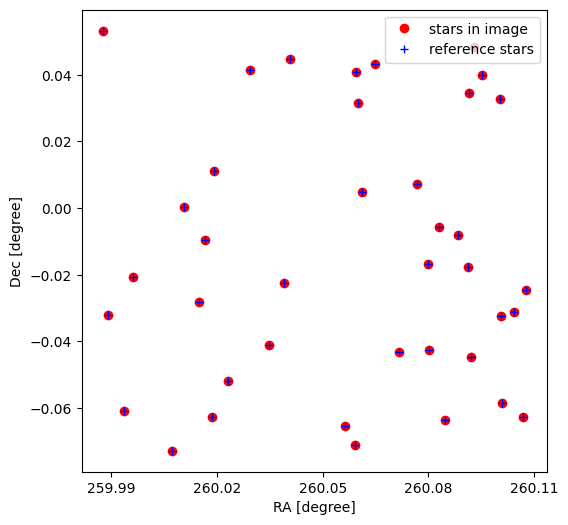

In [114]:
fig, axes = plt.subplots(1, 1, figsize= (6, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes.set_ylabel("Dec [degree]")
axes.set_xlabel("RA [degree]")
axes.xaxis.set_major_locator(MaxNLocator(5))
axes.legend(loc=1)

### 更新底片模型

In [115]:
# match_xi_gaia, match_eta_gaia = cel_ideal_coord(refcat_ra_now, refcat_dec_now, pointing_ra, pointing_dec)
# Y_xi = match_xi_gaia / (np.pi / 180)
# Y_eta = match_eta_gaia / (np.pi / 180)
# sext_out_x = df["XWIN_IMAGE"]
# sext_out_y = df["YWIN_IMAGE"]
# A_CD = cal_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, Y_xi, Y_eta, 4)

# match_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD, 4)
# match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

# dis_ra = (match_radec[0] - refcat_ra_now) * 3600000
# dis_dec = (match_radec[1] - refcat_dec_now) * 3600000
# np.std(dis_ra)

In [116]:
# 全体星应用
sext_out_x = sext_out_filter[:]["XWIN_IMAGE"]
sext_out_y = sext_out_filter[:]["YWIN_IMAGE"]
# sext_out_mag_bp = sext_out_filter[:][f"mag_{band}"]
sext_out_mag_auto = sext_out_filter[:]["MAG_AUTO"]

# sext_out_x = df["XWIN_IMAGE"]
# sext_out_y = df["YWIN_IMAGE"]
# sext_out_mag = df["Gmag(mag)"]

sext_out_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD, cof)
sext_out_radec = ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

# 全体再次匹配
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magg": ref_filter["magg"], "magr": ref_filter["magr"], "magi": ref_filter["magi"], "pos_x": ref_filter["Pos_X"], "pos_y": ref_filter["Pos_Y"]})
side_threshold = 0.00001
match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

# 更新底片模型及
match_res_xi_gaia_all, match_res_eta_gaia_all = cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all / (np.pi / 180)
Y_eta = match_res_eta_gaia_all / (np.pi / 180)

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)
# match_res_mag_bp_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_auto_all = np.zeros_like(match_res_xi_gaia_all)
for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]
    # match_res_mag_bp_all[index] = sext_out_mag_bp[int(i)]
    match_res_mag_auto_all[index] = sext_out_mag_auto[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag_g = match_res_all[:, 5]
match_mag_auto = match_res_mag_auto_all

print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
# cof = 2
A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)

print(A_CD)

# 再应用底片模型
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof)

the matched stars 2792
[[ 1.38968319e-05 -1.38891384e-05  2.89649147e-10 -4.28145173e-14
   5.84549052e-15 -6.12454574e-14  2.53636991e-18 -9.56221531e-18
   8.58956429e-18 -1.04759385e-18 -4.60014208e-22  6.92531561e-22
   3.46692313e-21  7.89396563e-22  1.66592987e-21]
 [-1.19731120e-05  6.84864585e-12  1.38890399e-05  1.64227622e-15
  -1.20971335e-14 -4.42817640e-14 -2.30418278e-18 -8.40507423e-19
   3.50697245e-18 -3.74589216e-18 -1.61721915e-23  7.06839465e-22
  -1.57297966e-21  4.16460976e-22  2.21879306e-21]]
3.150069365588686 3.070133046504373 4


In [117]:
store = np.zeros((4, 2))
for cof in [1, 2, 3, 4]:
    match_res = np.array(match_lib)

    match_res_ra_sex = match_res[:, 0:3].flatten()
    match_res_dec_sex = match_res[:, 3:6].flatten()

    match_res_xindex_sex = match_res[:, 6:9].flatten()
    match_res_yindex_sex = match_res[:, 9:12].flatten()

    match_res_ra_gaia = match_res[:, 12:15].flatten()
    match_res_dec_gaia = match_res[:, 15:18].flatten()

    # sext 结果
    counts = Counter(match_res_ra_sex)
    index_num = np.sort(np.array(list(counts.values())))[-8]
    index_num = 100
    temp_index = np.array(list(counts.values())) > index_num
    match_res_ra_sex_uniqe = list((counts.keys()))
    match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

    counts = Counter(match_res_dec_sex)
    match_res_dec_sex_uniqe = list((counts.keys()))
    match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

    counts = Counter(match_res_xindex_sex)
    match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

    counts = Counter(match_res_yindex_sex)
    match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

    # gaia 结果
    match_res_ra_gaia_uniqe = []
    match_res_dec_gaia_uniqe = []
    for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
        counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
        temp_index = np.array(list(counts.values())) == max(list(counts.values()))
        match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

        counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
        temp_index = np.array(list(counts.values())) == max(list(counts.values()))
        match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
    match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)

    # 把匹配到的gaia星转到理想坐标系
    match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

    # 找到匹配图像中匹配的星的像素坐标
    match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
    match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
    for index, i in enumerate(match_res_xindex_sex_uniqe):
        match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
        match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

    # 底片模型计算
    match_x = match_res_x_sext_uniqe
    match_y = match_res_y_sext_uniqe
    Y_xi = match_res_xi_gaia_uniqe / (np.pi / 180)
    Y_eta = match_res_eta_gaia_uniqe / (np.pi / 180)
    # cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))

    A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)
    A_CD_TEMP = A_CD

    # 应用
    match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
    # match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD)
    match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

    # 全体星应用
    sext_out_x = sext_out_filter[:]["XWIN_IMAGE"]
    sext_out_y = sext_out_filter[:]["YWIN_IMAGE"]
    # sext_out_mag_bp = sext_out_filter[:][f"mag_{band}"]
    sext_out_mag_auto = sext_out_filter[:]["MAG_AUTO"]

    # sext_out_x = df["XWIN_IMAGE"]
    # sext_out_y = df["YWIN_IMAGE"]
    # sext_out_mag = df["Gmag(mag)"]

    sext_out_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD, cof)
    sext_out_radec = ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

    sext_out_ra = sext_out_radec[0]
    sext_out_dec = sext_out_radec[1]

    # 全体再次匹配
    refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magg": ref_filter["magg"], "magr": ref_filter["magr"], "magi": ref_filter["magi"], "pos_x": ref_filter["Pos_X"], "pos_y": ref_filter["Pos_Y"]})
    side_threshold = 0.00001
    match_res_all = []

    for i in range(len(sext_out_ra)):
        temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
        index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
        if np.sum(index) == 1:
            match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

    match_res_all = np.array(match_res_all)

    # 更新底片模型及
    match_res_xi_gaia_all, match_res_eta_gaia_all = cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
    Y_xi = match_res_xi_gaia_all / (np.pi / 180)
    Y_eta = match_res_eta_gaia_all / (np.pi / 180)

    match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
    match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)
    # match_res_mag_bp_all = np.zeros_like(match_res_xi_gaia_all)
    match_res_mag_auto_all = np.zeros_like(match_res_xi_gaia_all)
    for index, i in enumerate(match_res_all[:, 2]):
        match_res_x_sext_all[index] = sext_out_x[int(i)]
        match_res_y_sext_all[index] = sext_out_y[int(i)]
        # match_res_mag_bp_all[index] = sext_out_mag_bp[int(i)]
        match_res_mag_auto_all[index] = sext_out_mag_auto[int(i)]

    match_x = match_res_x_sext_all
    match_y = match_res_y_sext_all
    match_mag_g = match_res_all[:, 5]
    match_mag_auto = match_res_mag_auto_all

    # cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
    # cof = 2
    A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)


    # 再应用底片模型
    match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
    match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
    gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
    gaia_xieta = cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


    # 残差
    dis_xi = (match_xieta[0] - gaia_xieta[0])
    dis_eta = (match_xieta[1] - gaia_xieta[1])
    dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
    dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

    print(np.std(dis_ra), np.std(dis_dec), cof)
    store[cof-1, 0] = np.std(dis_ra)
    store[cof-1, 1] = np.std(dis_dec)
store

3.204094519771831 3.089361682197902 1
3.2396783530622364 3.076721434466645 2
3.131958231108595 3.05933766683204 3
3.150069365588686 3.070133046504373 4


array([[3.20409452, 3.08936168],
       [3.23967835, 3.07672143],
       [3.13195823, 3.05933767],
       [3.15006937, 3.07013305]])

In [118]:
store

array([[3.20409452, 3.08936168],
       [3.23967835, 3.07672143],
       [3.13195823, 3.05933767],
       [3.15006937, 3.07013305]])

In [119]:
fp_out_sext

'/home/fangwf/code/csst_mci_multiband_0614/sext_out/C2_r_1200_out.fits'

In [120]:
# match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "MAG_BP": match_mag_bp, "MAG_AUTO": match_mag_auto})

# with open(f'match_res/match_{band}_{unkonw_index}_res.pkl', 'wb') as f:
#     pickle.dump(match_res_pickle, f)

### 残差图

In [121]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

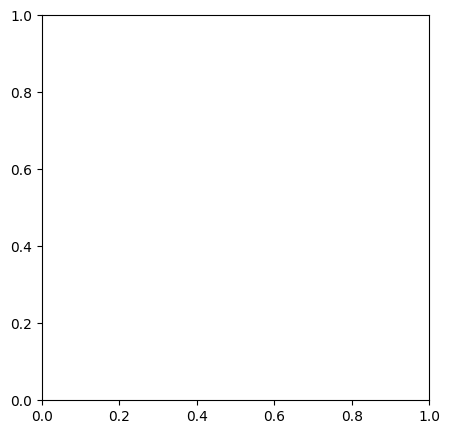

In [122]:
# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):

#         # 各个区域画图
#         dict_mag_dis.update({str(i)+str(j): []})
#         index = (bins_x_id == i) & (bins_y_id == j)
#         match_mag_box = match_mag_bp[index]
#         match_x_box = match_x[index]
#         match_y_box = match_y[index]
#         dis_ra_box = dis_ra[index]
#         dis_dec_box = dis_dec[index]
#         dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
#         dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)
#         axes[i][j].plot(match_mag_ra_box, dis_ra_box, '.', c='blue', label="ra")
#         axes[i][j].plot(match_mag_dec_box, dis_dec_box, '.', c='red', label="dec")
#         axes[i][j].set_xlabel("mag")
#         axes[i][j].set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
#         axes[i][j].legend()

        # 
        # bins_num_mag_box = 8
        # bins_mag_box = np.linspace(np.min(match_mag_box) * 0.99, max(match_mag_box) * 1.01, bins_num_mag_box + 1)
        # bin_centers_mag_box = (bins_mag_box[:-1] + bins_mag_box[1:]) / 2
        # dict_mag_dis[str(i)+str(j)].append(bin_centers_mag_box)

        # bins_mag_box_dis = []
        # bins_mag_box_id = np.digitize(match_mag_box, bins_mag_box) - 1
        # for k in range(0, bins_num_mag_box):
        #     index_mag = bins_mag_box_id == k
        #     bins_mag_box_dis.append(np.std(dis_box[index_mag]))
        # dict_mag_dis[str(i)+str(j)].append(bins_mag_box_dis)
            


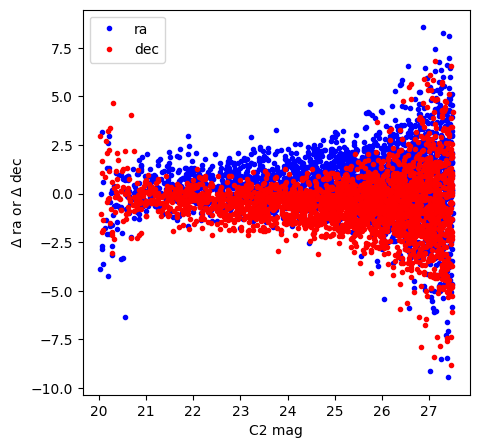

In [123]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag_g[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        # dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        # dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)

        # index_ra = (match_mag_ra_box < -5) & (match_mag_ra_box > -14)
        # index_dec = (match_mag_dec_box < -5) & (match_mag_dec_box > -14)

        dis_ra_box, dis_dec_box, match_mag_radec_box, filter = sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_ra_dec = (match_mag_radec_box < 29) & (match_mag_radec_box > 20)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_radec_box[index_ra_dec], dis_ra_box[index_ra_dec], '.', c='blue', label="ra")
        axe.plot(match_mag_radec_box[index_ra_dec], dis_dec_box[index_ra_dec], '.', c='red', label="dec")
        axe.set_xlabel(f"{band} mag")
        axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axe.legend()

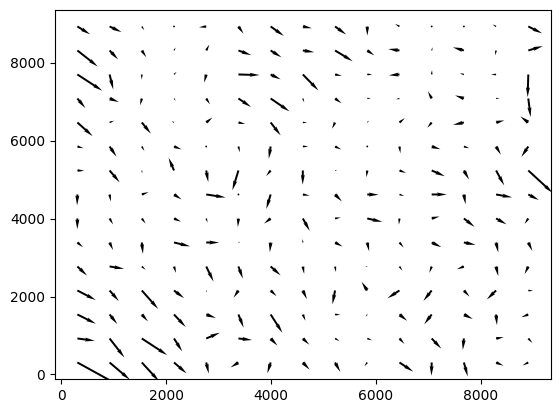

In [124]:
bins_num = 15
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_ra_dec], match_y[filter][index_ra_dec], dis_ra[filter][index_ra_dec], dis_dec[filter][index_ra_dec]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), headwidth=2, width=0.004, scale=50)

In [125]:
# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         axes[i][j].plot(dict_mag_dis[str(i)+str(j)][0], dict_mag_dis[str(i)+str(j)][1], '.')
#         axes[i][j].set_xlabel("mag")
#         axes[i][j].set_ylabel(r"$\sigma$ dec")


In [126]:
# dict_mag_dis["21"]

# x = dict_mag_dis["21"][0]
# y = dict_mag_dis["21"][1]

# X = np.array([np.ones_like(x), x]).T
# Y = y
# A = np.linalg.inv(X.T @ X) @ X.T @ Y

# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][1], '.')
# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][0] * A[1] + A[0], '.')

### test

In [127]:
# # create bins
# bins_num = 4
# bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
# bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# # bins' centers of all box
# bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
# bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
# bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# # calculate distortion error model
# distort_sum_bins = np.zeros((bins_num, bins_num))
# distort_sum_values_x = np.zeros((bins_num, bins_num))
# distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
# [distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

# distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
# distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# # mag-distortion
# bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         index = (bins_x_id == i) & (bins_y_id == j)
#         axes[i][j].plot(match_mag[index] * match_x[index], dis_dec[index], '.')

# ax = plt.matshow(distort_sum_bins)
# plt.colorbar(ax.colorbar, fraction=0.025)

In [128]:
# fig, axes = plt.subplots(1, 2)
# axes[0].quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), scale=1500)

# axes[1].matshow(distort_mean_values_x)

# ax = plt.matshow(distort_mean_values_x)
# plt.colorbar(ax.colorbar, fraction=0.025)
# plt.title("matrix X");
# plt.show()